# HW3 due 5p Fri Oct 29 2021

You are welcome (and encouraged) to work with others, but each individual must submit their own writeup.

You are welcome to use analytical and numerical computational tools; if you do, include the **commented** sourcecode in your submission (e.g. the .ipynb file).

You are welcome to consult websites, textbooks, and other materials; if you do, include a full citation in your writeup (e.g. the .ipynb file).

**Important:** before you do any work in the Colaboratory notebook, click "File -> Save a copy in Drive ..." and rename the file to something memorable.


# 0. [Nakseung Choi]; [He/His/Him]

a. Approximately how many hours did you spend on this assignment?
   12 hours
b. Were there specific problems that took much longer than others?
    problem 2 f
c. What class meeting(s) did you participate in this week?
   both
d. What timezone(s) were you working in this week?
   whenever I had time I worked on this homework.

In [2]:
# "magic" commands, prefaced with "%", changes settings in the notebook

# this ensures plots are embedded in notebook web page
%matplotlib inline

# pdb = Python debugger, so this command turns the debugger OFF
%pdb off

Automatic pdb calling has been turned OFF


In [3]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# animation
from matplotlib import animation as ani
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym


In [4]:
# test whether this is a Colaboratory or Jupyter notebook
try:
  import google.colab
  COLAB = True
  print('Colaboratory Notebook')
except:
  COLAB = False
  print('Jupyter Notebook')

Colaboratory Notebook


In [5]:
# Colab notebook
if COLAB:
  # pip = Python package manager; "!" means "run at system level"
  !pip install control
  !pip install JSAnimation
  
  # render SymPy equations nicely in Colaboratory Notebook
  def colab_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
  
  sym.init_printing(use_latex="mathjax",latex_printer=colab_latex_printer)

# Jupyter notebook
else:
  init_printing(use_latex='mathjax')
    

# Python's Control Systems Toolbox
import control as ctrl

# SciPy module that implements many of the routines in ctrl
from scipy import signal as sig

     |████████████████████████████████| 339 kB 24.7 MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344928 sha256=321060c1afc4480aebf7509839bc40007ab34c33f45ac69cfb77eafbde5299f1
  Stored in directory: /root/.cache/pip/wheels/5b/64/54/70faad181d7baff1184541ca00c9a2efa633acd0a811831d30
Successfully built control
  Created wheel for JSAnimation: filename=JSAnimation-0.1-py3-none-any.whl size=11425 sha256=916a38b476d9e466489c40129ad5ca660bd7fbb030752d21364d0a9e50bfb94b
  Stored in directory: /root/.cache/pip/wheels/0e/4e/3d/05fb8cca2646ee0bbfbce17c40a970f48d5e0698b9e5aaa91f
Successfully built JSAnimation


In [6]:
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# 1. proportional-integral control

This problem considers the following standard negative feedback block diagram.

![negative feedback block diagram](http://faculty.washington.edu/sburden/447/447-hw1-feedback.png)

***Purpose:*** you will analyze and synthesize a ***proportional-integral*** controller
$$ C(s) = k_P + k_I/s \iff u(t) = k_P e(t) + k_I \int_0^t e(\tau) d\tau $$ 
for the purpose of ***reference tracking***.  Specifically, you'll apply this controller to a first-order process model $P(s) = b / (s + a)$ to obtain the closed-loop transfer function $G_{yr}$.

**We seek to tune the controller parameters $k_P, k_I$ to obtain complex-conjugate roots $-\sigma_d \pm j \omega_d$ for the closed-loop system, i.e. we want the characteristic polynomial of $G_{yr}$ to be
$$(s + \sigma_d + j \omega_d) (s + \sigma_d - j \omega_d) = s^2 + 2\sigma_d s + \sigma_d^2 + \omega_d^2.$$**

a. By matching coefficients that multiply the same power of the variable $s$ in the actual and desired characteristic polynomials, express $k_P$ and $k_I$ in terms of $\sigma_d,\omega_d,a,b$.
$$$$
$$a(s)=s^{2}+(a+bk_{P})s+bk_{I}$$
$$$$
$$a+bk_{P} = 2σ_{d}$$
$$$$
$$k_{P} = \frac{2σ_{d}-a}{b}$$
$$$$
$$bk_{I} = σ^{2}_{d}+w^{2}_{d}$$
$$$$
$$k_{I}=\frac{σ^{2}_{d}+w^{2}_{d}}{b}$$
$$$$




b. Validate your result from (a) using a numerical simulation of the closed-loop system with parameters $a = 1$, $b = 1$:  choose $\sigma_d$, $\omega_d$, determine the corresponding $k_P$, $k_I$, and plot the system's ***step response***, that is, the output corresponding to a reference $r(t)$ that is equal to zero for $t < 0$ and equal to $1$ for $t \geq 0$.
$$$$
$$a = 1, b = 1$$
$$$$
$$k_{P}=2σ_{d}-a, k_{I}=σ^{2}_{d}+w^{2}_{d}$$
$$$$

**According to the preceding analyses, the convergence rate can be made arbitrarily fast (i.e. $\sigma_d$ can be made arbitrarily large) by making the controller parameters $k_P,k_I$ large. In practice, such *high-gain feedback* can excite *unmodeled dynamics* and lead to instability.**

**To see how this can happen, suppose unmodeled dynamics in $P(s)$ (e.g. dynamics of sensors, actuators, vibratory modes, electromagnetic coupling, etc.) have time constant $T > 0$ (assume $-1/T \ll -a$, so we were initially justified in neglecting these dynamics in our model because they are stable and converge much faster than the original modeled dynamics).  Including these dynamics yields the process model**

$$ P(s) = \frac{b}{(s + a)(1 + sT)}. $$

c. Determine the characteristic polynomial of the closed-loop transfer function $G_{yr}$.
$$$$
$$ P(s) = \frac{b}{(s + a)(1 + sT)}, C(s)=k_{P}+\frac{k_{I}}{s}$$
$$$$
$$G_{yr}=\frac{P(s)C(s)}{1+P(s)C(s)}$$
$$$$
$$\frac{(\frac{b}{(s + a)(1 + sT)})(k_{P}+\frac{k_{I}}{s})}{1+(\frac{b}{(s + a)(1 + sT)})(k_{P}+\frac{k_{I}}{s})}$$
$$$$
$$\frac{\frac{bk_{P}s+k_{I}b}{(s+a)(1+sT)s}}{\frac{s(s+a)(1+sT)+sbk_{P}+bk_{I}}{s(s+a)(1+sT)}}$$
$$$$
$$G_{yr}=\frac{bk_{P}s+k_{I}b}{Ts^{3}+s^{2}(aT+1)+s(bk_{P}+a)+bk_{I}}$$
$$$$
$$a(s)=s^{3}T+(1+aT)s^{2}+(a+bk_{P})s+bk_{I}$$
$$$$
$$a(s)=Ts^{3}+(1+aT)s^{2}+2σ_{d}s+σ^{2}_{d}+w^{2}_{d}$$
$$$$

d. Apply the *Routh-Hurwitz stability criterion* to determine algebraic conditions that must be satisfied by $a,b,k_P,k_I,T$ for the closed-loop system to be stable.
$$$$
$$a(s)=s^{3}+(\frac{1}{T}+a)s^{2}+\frac{a+bk_{P}}{T}s+\frac{bk_{I}}{T}$$
$$$$
**Using $a_{1},a_{2},a_{3}>0$ and $a_{1}a_{2}>a_{3}$ for third quadratic rules**
$$\frac{1}{T}+a>0$$
$$$$
$$\frac{(a+bk_{P})}{T}>0$$
$$$$
$$\frac{bk_{I}}{T}>0$$
$$$$
$$(\frac{1}{T}+a)(\frac{a+bk_{P}}{T})>\frac{bk_{I}}{T}$$
$$$$
$$\frac{(1+aT)(a+bk_{P})}{bk_{I}}>T$$
$$$$
**Conclude that $\sigma_d$ is limited by $T$, i.e. the convergence rate of a PI controller applied to a first-order process is limited by the characteristic time constant of unmodeled dynamics.**

$$$$
$$a(s)=s^{3}+(\frac{1}{T}+a)s^{2}+\frac{(2σ_{d})}{T}s+\frac{σ^{2}_{d}+w^{2}_{d}}{T}$$
$$$$
$$(\frac{1}{T}+a)>0 <-> aT>-1$$
$$$$
$$\frac{2σ_{d}}{T}>0$$
$$$$
$$\frac{σ^{2}_{d}+w^{2}_{d}}{T}>0$$
$$$$
$$(\frac{1}{T}+a)(\frac{2σ_{d}}{T})>(\frac{σ^{2}_{d}+w^{2}_{d}}{T})$$
$$$$
**$w_{c}$ is limited by T.**
$$$$

e. Validate your result from (d) using a numerical simulation of the closed-loop system with $a = 1$, $b = 1$, $T = 0.1$:  choose $k_P$, $k_I$ such that the Routh-Hurwitz criteria are (i) satisfied (so the closed-loop system is stable) and (ii) violated (so the closed-loop system is unstable), and provide plots showing the step response in these two cases.



    s + 7
-------------
s^2 + 2 s + 7



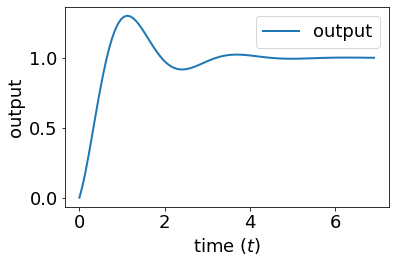

In [13]:
#This is the solution for P.1 (b)

#assumming omega=1 and segma=1, 
#declaring variables for a, b, kp, and ki and setting values.
a=1
b=1
kp=1
ki=7

#setting a numerator and denominator. 
num = [b*kp,b*ki]
deno = [1,a+kp*b,ki*b]
tf = ctrl.TransferFunction(num,deno)#this is going to generate a transfer function for num and deno
print(tf)
t,y = ctrl.step_response(tf)#Step_response of tf

#plotting
plt.plot(t,y, label = 'output', linewidth = 2)
#plt.plot(T, y, 'b', label ='y',linewidth=2)
plt.xlabel(r'time ($t$)')
plt.ylabel(r'output')
plt.tight_layout()
plt.legend()

pass

The system is *unstable*

          10 s + 150
------------------------------
0.1 s^3 + 1.1 s^2 + 11 s + 150

The system is *stable*

          17 s + 150
------------------------------
0.1 s^3 + 1.1 s^2 + 18 s + 150



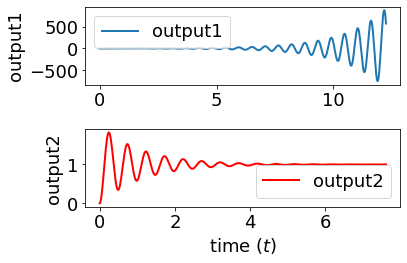

In [54]:
#This is my solution for problem 1 (e) 
#declaring variables, a, b, T, kp, kp1, and ki and setting values.
a=1
b=1
T=0.1
kp = 10
kp1 = 17
ki= 150
n = 2
#Routh-Hurwitz criteria for a cubic formula
#it is necessary to divide coefficient a1,a2,a3 by a0 to obtain 
#characteristic polynomial in the form expected by the Routh-Hurwitz stability criteria.
a1 = (1/T)+a
a2 = (a+b*kp)/T
a1a2 = ((1/T)+a)*((a+(b*kp))/T)
a3 = (b*ki)/T
if(a1 > 0) and (a2 > 0) and (a3 >0) and (a1a2 > a3):
    print('The system is *stable*')
else:
    print('The system is *unstable*')   
#setting a numerator and denominator. 
num = [b*kp,b*ki]
deno = [T,(a*T+1),b*kp+a,b*ki]
tf = ctrl.TransferFunction(num,deno)#this is going to generate a transfer function for num and deno
print(tf)
t,y = ctrl.step_response(tf)#Step_response of tf
#plotting
plt.subplot(2,1,1)
plt.plot(t,y, label = 'output1', linewidth = 2)
#plt.plot(T, y, 'b', label ='y',linewidth=2)
plt.ylabel(r'output1')
plt.tight_layout()
plt.legend()

##with a second kp values
#Routh-Hurwitz criteria for a cubic formula with a second kp value
a2a2 = (a+b*kp1)/T 
a1a2a1a2 = ((1/T)+a)*((a+(b*kp1))/T)
if(a1 > 0) and (a2a2 > 0) and (a3 >0) and (a1a2a1a2 > a3):
    print('The system is *stable*')
else:
    print('The system is *unstable*')   
num1 = [b*kp1,b*ki]
deno1 = [T,(a*T+1),b*kp1+a,b*ki]
tf1 = ctrl.TransferFunction(num1,deno1)#this is going to generate a transfer function for num and deno
print(tf1)
t,y = ctrl.step_response(tf1)#Step_response of tf
#plotting
plt.subplot(2,1,2)
plt.plot(t,y, 'r', label = 'output2', linewidth = 2)
plt.xlabel(r'time ($t$)')
plt.ylabel(r'output2')
plt.tight_layout()
plt.legend()

pass

# 2. spring-mass-damper a deux
Consider the following spring-mass-damper system:
![spring-mass](http://faculty.washington.edu/sburden/447/447-hw1-spring-mass.png)
The input to this system is the sinusoidal motion of the end of the rightmost spring. 
Applying Newton's laws to determine the forces acting on both masses, we find two coupled second-order DE that model the system's dynamics:

$$ m\ddot{q}_1 = - c \dot{q}_1 - k q_1 + k (q_2 - q_1), $$

$$ m\ddot{q}_2 = - c \dot{q}_2 + k (u - q_2) - k (q_2 - q_1). $$

## change-of-coordinates

***Purpose:*** observe how a clever change-of-coordinates can simplify analysis of a complex system's dynamics.  ***Note:*** you ***do not*** need to solve the DEs in (a.--d.).

a. Combine the two second-order DE above to obtain one fourth-order DE with $u$ as the input and $q_1$ as the output.  (***Hint:*** solve the first equation for $q_2$ in terms of $q_1$ and substitute this into the second equation. ***Note:*** this DE is hard to solve -- since the characteristic polynomial is fourth-order, you can't easily solve for the roots needed to obtain the ***homogeneous solution***.)

$$$$
$$kq_{2}=m\ddot{q_{1}}+c\dot{q_{1}}+2kq_{1}$$
$$$$
$$q_{2}=\frac{m}{k}\ddot{q_{1}}+\frac{c}{k}\dot{q_{1}}+2q_{1}$$
$$$$
**Substituting the equation into equation 2,**
$$$$
$$m\ddot{q}_2 = - c \dot{q}_2 + k (u - q_2) - k (q_2 - q_1)$$
$$$$
$$m(\frac{m}{k}\ddddot{q_{1}}+\frac{c}{k}\dddot{q_{1}}+2\ddot{q_{1}})=-c(\frac{m}{k}\dddot{q_{1}}+\frac{c}{k}\ddot{q_{1}}+2\dot{q_{1}})+k(u-(\frac{m}{k}\ddot{q_{1}}+\frac{c}{k}\dot{q_{1}}+2q_{1}))-k((\frac{m}{k}\ddot{q_{1}}+\frac{c}{k}\dot{q_{1}}+2q_{1})-q_{1})$$
$$\frac{m^{2}}{k}\ddddot{q_{1}}+\frac{2mc}{k}\dddot{q_{1}}+(4m+\frac{c^{2}}{k}\ddot{q_{1}})+4c\dot{q_{1}}+3kq_{1}=ku$$
$$$$

b. Rewrite the original two second-order DE in terms of 
$p_1 = \frac{1}{2}(q_1 + q_2)$ 
and 
$p_2 = \frac{1}{2} (q_1 - q_2)$.   (***Hint:*** solve for $q_1$ and $q_2$ in terms of $p_1$ and $p_2$ and substitute into the original DE.  ***Note:*** by adding and subtracting the resulting equations, you should be able to obtain two second-order DE that are decoupled, that is, they can be solved independently; two second-order DE are ***much*** easier to solve than the one fourth-order DE you obtained in (a.).)

$$$$
$$\ddot{p_{1}}=\frac{1}{2}(\ddot{q_{1}}+\ddot{q_{2}})=\frac{1}{m}(-c\dot{p_{1}}-kp_{1}+\frac{k}{2}u)$$
$$$$
$$\ddot{p_{2}}=\frac{1}{2}(\ddot{q_{1}}-\ddot{q_{2}})=\frac{1}{m}(-c\dot{p_{2}}-3kp_{2}-\frac{k}{2}u)$$
$$$$


c. Translate the original two DE to matrix/vector form using state vector $x = (q_1,\dot{q_1},q_2,\dot{q_2})$ (i.e. determine matrices $A$, $B$ such that $\dot{x} = A x + B u$).
$$$$
$$ \dot{x}=\left[\begin{matrix} \dot{q_{1}} \\ \ddot{q_{1}} \\ \dot{q_{2}} \\ \ddot{q_{2}} \end{matrix}\right] = \left[\begin{matrix} 0 && 1 && 0 && 0 \\ -\frac{2k}{m} && -\frac{c}{m} && \frac{k}{m} && 0 \\ 0 && 0 && 0 && 1 \\ \frac{k}{m} && 0 && -\frac{2k}{m} && -\frac{c}{m} \end{matrix}\right] \left[\begin{matrix} q_{1} \\ \dot{q_{1}} \\ q_{2} \\ \dot{q_{2}} \end{matrix}\right] + \left[\begin{matrix} 0 \\ 0 \\ 0 \\ \frac{k}{m} \end{matrix}\right]u=Ax+bu$$
$$$$

d. Translate the two DE from (b.) to matrix/vector form using state vector $z = (p_1,\dot{p}_1,p_2,\dot{p}_2)$.  Noting that the system's $``A"$ matrix is block-diagonal, determine $A_1, A_2\in\mathbb{R}^{2\times 2}$ and $B_1, B_2\in\mathbb{R}^{2\times 1}$ such that
$$ \dot{z} = \left[ \begin{matrix} A_1 & 0 \\ 0 & A_2 \end{matrix} \right] z + \left[ \begin{matrix} B_1 \\ B_2 \end{matrix} \right] u.$$

$$$$
$$z=(p_{1},\dot{p_{1}},p_{2},\dot{p_{2}})$$
$$$$
$$\dot{z}=\left[\begin{matrix} \dot{p_{1}} \\ \ddot{p_{1}} \\ \dot{p_{2}} \\ \ddot{p_{2}} \end{matrix}\right] = \left[\begin{matrix} 0 && 1 && 0 && 0 \\ -\frac{k}{m} && -\frac{c}{m} && 0 && 0 \\ 0 && 0 && 0 && 1 \\ 0 && 0 && -\frac{3k}{m} && -\frac{c}{m} \end{matrix}\right] \left[\begin{matrix} z_{1} \\ \dot{z_{1}} \\ z_{2} \\ \dot{z_{2}} \end{matrix}\right] + \left[\begin{matrix} 0 \\ \frac{k}{2m} \\ 0 \\ -\frac{k}{2m} \end{matrix}\right]u$$
$$$$

***Observe:***  in matrix/vector form, decoupling between subsystems manifests with block-diagonal structure in the $``A"$ matrix.

***Bonus (1 point for correctness):*** determine the matrix $T$ such that $z = T x$.


## resonance

***Purpose:*** use computational tools to investigate a complex system's steady-state behavior in the time- and frequency- domain.

e. Setting $m = 250$, $k = 50$, $c = 10$, plot the motion of the first and second masses in response to an
input motion $u = a \sin(\omega t)$ with $\omega = 1$ rad/sec and $a = 1$ cm. 
How long does it take for the system to reach $2\%$ of its steady-state oscillation amplitude starting from the origin?

f. Plot the steady-state amplitude of the motion of the first mass as a function of the frequency of the input, $\omega$.  (***Hint:***  you can either derive the transfer function from your answer to (a.) above, or you can run many (~100) simulations to create this plot; experiment with different ranges of $\omega$ until you find a range that demonstrates two resonant frequencies (sharp peaks) in the plot.  You may find it helpful to use the `numerical_simulation` function defined and applied in the [lecture examples notebook](https://colab.research.google.com/github/sburden/447/blob/master/447_lec_examples.ipynb).)

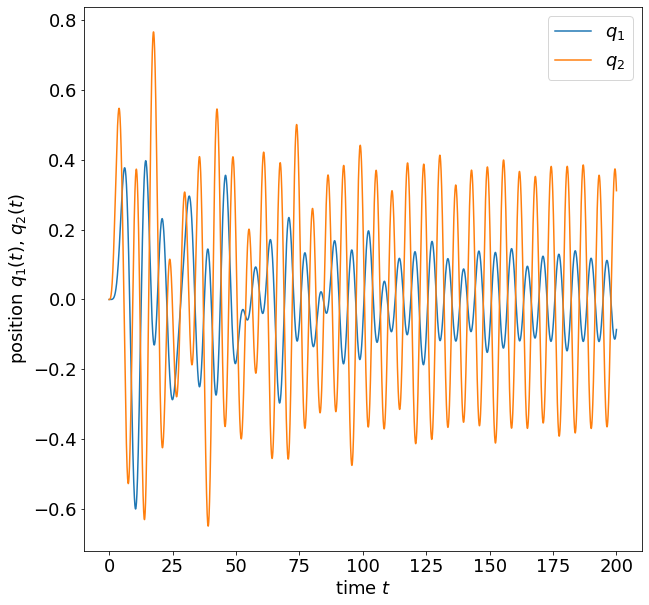

In [43]:
# Solution for e
import numpy as np

#declaring variables with proper values.
m,c,k,A,omega,T,dt=250,10,50,1,1,200,1e-2

# vector field
def f(t,x,u):
  q1,q2,dq1,dq2 = x
  ddq1 = (-c*dq1 - k*q1 + k*(q2-q1)) / m
  ddq2 = (-c*dq2 + k*(u-q2) - k*(q2-q1)) / m
  return np.array([dq1,dq2,ddq1,ddq2])

# zero initial state
x0 = np.zeros(4)
# sinusoidal input
def u(t):
  ut = A*np.sin(omega*t)
  return ut

t_,x_ = numerical_simulation(f,T,x0,ut=u,dt=dt)
q1_,q2_ = x_[:,0],x_[:,1]
fig = plt.figure(figsize=(10,10));

import pylab as plt

# plot theta
plt.plot(t_,q1_,label=r'$q_1$')
plt.plot(t_,q2_,label=r'$q_2$')
plt.xlabel(r'time $t$')
plt.ylabel(r'position $q_1(t)$, $q_2(t)$')
plt.legend()


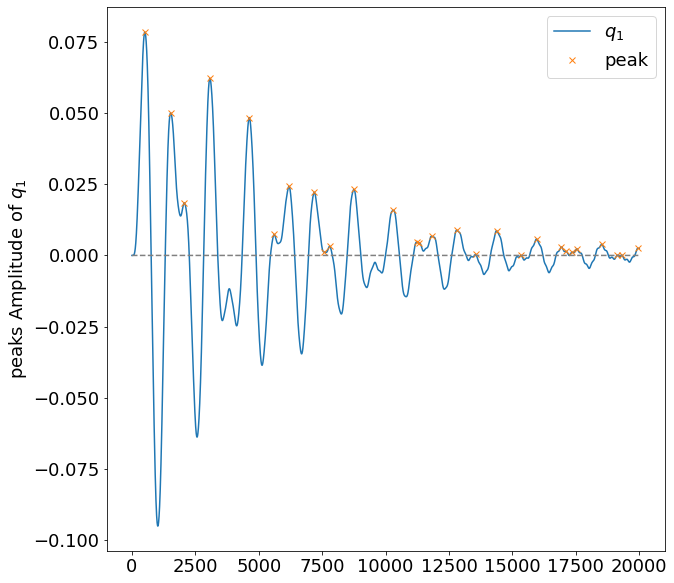

array([1019,  537, 1008, 1554,  983,  583,  997,  402,  204,  958, 1557,
        909,  111,  482,  992,  744,  827,  961,  614,  985,  178,  240,
        184,  984,  614,  176,  640])

In [52]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# Boolean array indicating times where signal is increasing
fig = plt.figure(figsize=(10,10));
t_,x_ = numerical_simulation(f,T,x0,ut=u,dt=dt)
q1_=x_[:,0]
peaks, _ = find_peaks(q1_,height=0)
plt.plot(q1_, label='$q_1$')
plt.plot(peaks, q1_[peaks], "x",label= 'peak')
plt.plot(np.zeros_like(q1_), "--", color="gray")
plt.ylabel('peaks Amplitude of $q_1$')
plt.legend()
plt.show()
np.diff(peaks)

steady-state amplitude reached after 27 peaks (199.5 time units)


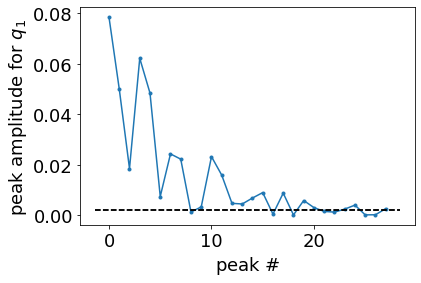

In [53]:
# the peaks calculation checks out
# and compute the steady-state amplitude by averaging the last 10 peaks
steady_state = q1_[peaks][-10:].mean()

plt.plot(q1_[peaks],'.-')
xlim = plt.xlim()
plt.plot(xlim,1.02*steady_state*np.ones(2),'k--')
plt.plot(xlim,0.98*steady_state*np.ones(2),'k--')
plt.xlabel(r'peak $\#$')
plt.ylabel(r'peak amplitude for $q_1$')

#how much time is required to reach +-2%
converged = np.abs((q1_[peaks] - steady_state)/steady_state > 0.02)
print('steady-state amplitude reached after %d peaks (%0.1f time units)'
      % (converged.nonzero()[0][-1],t_[peaks][converged][-1]))


Text(0, 0.5, 'steady-state amplitude')

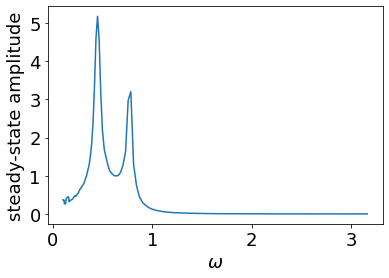

In [50]:
omegas = np.logspace(-1,.5,100)
steady_states = []

for omega in omegas:
  u = lambda t : A*np.sin(omega*t)
  t_,x_ = numerical_simulation(f,T,x0,ut=u,dt=dt)
  q1_,q2_ = x_[:,0],x_[:,1]
  increasing = np.diff(q1_) > 0
  peaks = np.diff(1*increasing) < 0
  peaks = np.hstack((False,peaks,False))
  steady_state = q1_[peaks][-10:].mean()
  steady_states.append(steady_state)

steady_states = np.asarray(steady_states)

plt.plot(omegas,steady_states)
plt.xlabel(r'$\omega$')
plt.ylabel(r'steady-state amplitude')


# 3. parametric stability

Consider the linear system

$$ \dot{x} = \left[\begin{matrix} 0 & 1 \\ 0 & -3 \end{matrix}\right]x + \left[\begin{matrix} -1 \\ 4 \end{matrix}\right] u. $$

## open-loop system

***Purpose:*** assess stability of an uncontrolled ("open-loop") system in state-space form using eigenvalues.

First, we'll consider the *open-loop* linear system's $``A"$ matrix,

$$ A = \left[\begin{matrix} 0 & 1 \\ 0 & -3 \end{matrix}\right]. $$

a. What are the eigenvalues of $A$?  How did you determine them?
$$$$
$$det(λI-A)=0$$
$$$$
$$det(λ\left[\begin{matrix} 1 & 0 \\ 0 & 1 \end{matrix}\right]-\left[\begin{matrix} 0 & 1 \\ 0 & -3 \end{matrix}\right])=0$$
$$$$
$$det(\left[\begin{matrix} λ & 0 \\ 0 & λ \end{matrix}\right]-\left[\begin{matrix} 0 & 1 \\ 0 & -3 \end{matrix}\right])=0$$
$$$$
$$det(\left[\begin{matrix} λ & -1 \\ 0 & λ+3 \end{matrix}\right])=0$$
$$$$
$$λ(λ+3)=0$$
$$$$
$$λ=0,-3$$

b. Is this system stable (all eigenvalues have negative real part) or unstable (one or more eigenvalues has zero or positive real part)?
$$$$
In order to define a stability of systems with eigenvalue(s), every value for λ must be equal to negative. Because λ contains a value, zero, this system is unstable.
$$$$
## closed-loop system

***Purpose:*** assess stability of a controlled ("closed-loop") system in state-space form using eigenvalues as a function of a parameter.

Now we'll consider the effect of the output feedback $u = \left[\begin{matrix} -k & 0 \end{matrix}\right] x$, which results in the following ***closed-loop*** $``A"$ matrix for the linear system:

$$ A = \left[\begin{matrix} k & 1 \\ -4k & -3 \end{matrix}\right]. $$

c. What are the eigenvalues of $A$?  How did you determine them?
$$$$
$$det(λI-A)=0$$
$$$$
$$det(λ\left[\begin{matrix} 1 & 0 \\ 0 & 1 \end{matrix}\right]-\left[\begin{matrix} k & 1 \\ -4k & -3 \end{matrix}\right])=0$$
$$$$
$$det(\left[\begin{matrix} λ & 0 \\ 0 & λ \end{matrix}\right]-\left[\begin{matrix} k & 1 \\ -4k & -3 \end{matrix}\right])=0$$
$$$$
$$det(\left[\begin{matrix} λ-k & -1 \\ 4k & λ+3 \end{matrix}\right])=0$$
$$$$
$$λ^2-3kλ+k=0$$
$$$$
$$λ=\frac{-(3-k)±\sqrt{(3-k)^2-4k}}{2}$$
$$$$
d. Plot the eigenvalues of $A$ in the complex plane for $k\ge 0$; annotate the plot with several values of $k$.

***Takeaway:*** this kind of plot is termed a ***root locus*** -- the eigenvalues are the *roots* of the characteristic polynomial $a(s)$ for $A$, and their plot is the *locus* of points that satisfy the homogenous equation $a(s) = 0$.  Later we'll learn more techniques for predicting and interpreting a linear system's root locus plot.  We'll pay particular attention to whether the eigenvalues lie in the left-half-plane, i.e. whether the system is stable.

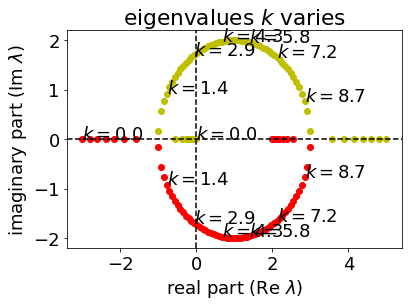

In [ ]:
import numpy as np
import pylab as plt
 
sqrt = np.lib.scimath.sqrt

#Choosing values of k for annotation
K = np.linspace(0,10,70)
lambda1 = (-(3 - K) + sqrt(((3 - K)**2) - 4*K)) / 2
lambda2 = (-(3 - K) - sqrt(((3 - K)**2) - 4*K)) / 2

# confirm the non-real eigenvalues are complex-conjugates
assert np.allclose(lambda1[np.abs(lambda1.imag) > 0.],
                   np.conj(lambda2[np.abs(lambda1.imag) > 0]))

#Axis labels
plt.title('eigenvalues $k$ varies')
plt.xlabel(r'real part ($\operatorname{Re}\ \lambda$)')
plt.ylabel(r'imaginary part ($\operatorname{Im}\ \lambda$)')

#Plotting values
plt.scatter(lambda1.real,lambda1.imag,color='y')
plt.scatter(lambda2.real,lambda2.imag,color = 'r')
#annotate every 10 of the computed eigenvalues
for k,lam1,lam2 in list(zip(K,lambda1,lambda2))[::10]:
  plt.annotate(r'$k=%0.1f$'%k,xy=(lam1.real,lam1.imag))
  plt.annotate(r'$k=%0.1f$'%k,xy=(lam2.real,lam2.imag))
#x- and y- limits and drawing axes
ylim = plt.ylim()
plt.plot(np.zeros(2),ylim,'k--')
xlim = plt.xlim()
plt.plot(xlim,np.zeros(2),'k--')
plt.xlim(xlim); plt.ylim(ylim);


In [ ]:
#source cited https://canvas.uw.edu/courses/1477838/discussion_topics/6718309 
#(#20fa midterm exam solution)